In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten, Reshape
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers


# Task 1: seq2seq RNN

In [6]:
n_timesteps_in = 100
n_timesteps_out = 80

n_features_in = 1
n_features_out = 1

## Synthetic data

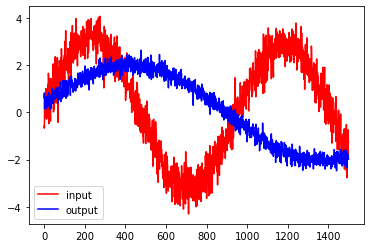

In [24]:
time_series_length = 1500
t = np.linspace(0, 5, time_series_length)
ts_input = np.cos(t)/5 + 3*np.sin(2*t) + 0.5*np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t)/3 + 2*np.sin(t) + 0.2*np.random.standard_normal(size=time_series_length)
plt.plot(ts_input, 'r', label = 'input')
plt.plot(ts_output,'b', label = 'output')

plt.legend()

### normalization

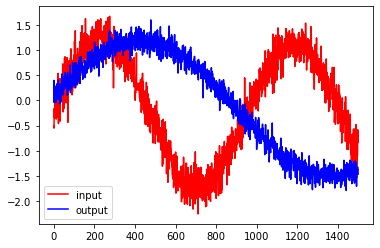

In [27]:
ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input')
plt.plot(ts_norm_output,'b', label = 'output')

plt.legend()

### splitting to test and train datasets

In [13]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

## creating dataset

In [5]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train + n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train + n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)

    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)
        

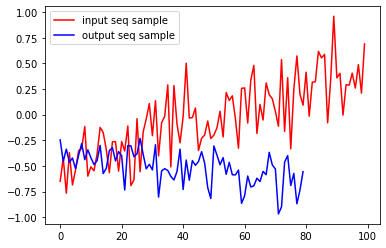

In [15]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()

plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()

### Reshaping to [n_samples, n_time_steps, n_features]

In [28]:
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [17]:
n_units = 128

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [18]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 80, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        66560       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [19]:
model.compile(optimizer='adam', loss='mse')

In [20]:
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 15s - loss: 0.6801 - val_loss: 0.4511 - 15s/epoch - 2s/step
Epoch 2/100
7/7 - 3s - loss: 0.5533 - val_loss: 0.4682 - 3s/epoch - 425ms/step
Epoch 3/100
7/7 - 3s - loss: 0.5420 - val_loss: 0.4248 - 3s/epoch - 429ms/step
Epoch 4/100
7/7 - 3s - loss: 0.5377 - val_loss: 0.4278 - 3s/epoch - 407ms/step
Epoch 5/100
7/7 - 3s - loss: 0.5258 - val_loss: 0.4163 - 3s/epoch - 492ms/step
Epoch 6/100
7/7 - 3s - loss: 0.5079 - val_loss: 0.3985 - 3s/epoch - 475ms/step
Epoch 7/100
7/7 - 3s - loss: 0.5093 - val_loss: 0.3994 - 3s/epoch - 422ms/step
Epoch 8/100
7/7 - 3s - loss: 0.5084 - val_loss: 0.4101 - 3s/epoch - 465ms/step
Epoch 9/100
7/7 - 3s - loss: 0.5063 - val_loss: 0.4506 - 3s/epoch - 484ms/step
Epoch 10/100
7/7 - 4s - loss: 0.5117 - val_loss: 0.3953 - 4s/epoch - 525ms/step
Epoch 11/100
7/7 - 3s - loss: 0.4980 - val_loss: 0.4405 - 3s/epoch - 455ms/step
Epoch 12/100
7/7 - 3s - loss: 0.4844 - val_loss: 0.3639 - 3s/epoch - 417ms/step
Epoch 13/100
7/7 - 3s - loss: 0.5688 - val_loss: 0

In [21]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

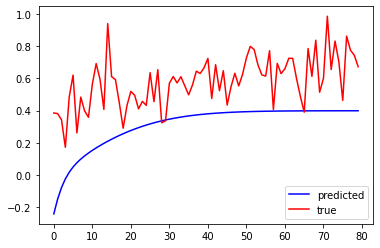

In [22]:
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()

# Task 2  (MNIST DIgits)

In [54]:
(x_train_raw, y_train), (x_test_raw, y_test) = mnist.load_data()
print(x_train_raw.shape[0], 'train samples')
print('image shape', x_train_raw[0].shape)

11501568/11490434 [==============================] - 2s 0us/step
60000 train samples
image shape (28, 28)


In [56]:
input_dim = 784
x_train = x_train_raw.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]

input shape:  784


## Model

In [58]:
optim = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
latent_dim = 100

In [59]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model  

In [60]:
discriminator = build_discriminator()
generator = build_generator()

discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [61]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [62]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9 
            
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

epoch:  0


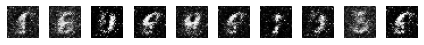

epoch:  20


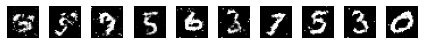

epoch:  40


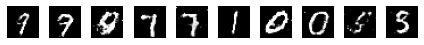

epoch:  60


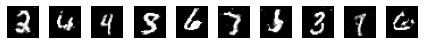

epoch:  80


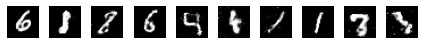

epoch:  100


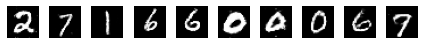

In [63]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)

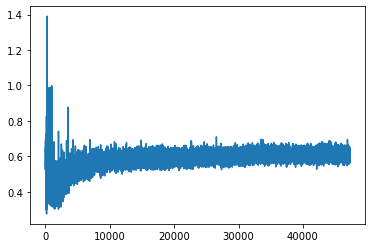

In [64]:
plt.plot(discrim_losses)